In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

In [2]:
from math import sqrt
from copy import deepcopy

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as o
import geotorch


DEVICE = None
# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

from src.distributions import *
from src.solvers import OTSolver
from src.plotters import Plotter
from src.loggers import TensorBoardLogger, WandbLogger

tb_logger = TensorBoardLogger()
wandb_logger = WandbLogger(project="optimal-transport", entity="_devourer_")

In [3]:
class SqOT:
    def __init__(self, l=.05, p=2):
        self.l = l
        self.p = p

    def __call__(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        return self.l * torch.norm(x - y, self.p, dim=1) ** self.p


class InnerGW:
    def __init__(self, l=.05):
        self.l = l

    def __call__(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        P = torch.einsum("ij,ik->jk", y, x)
        P = P / torch.norm(P)
        return self.l * torch.norm(x @ P - y, 2, dim=1) ** 2


class SqGW:
    def __init__(self, l=.05, alpha=1.):
        self.l = l
        self.alpha = alpha

    # def __call__(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    #     P = self._get_P(x, y)
    #     return self.l * (torch.norm(x @ P - y, 2, dim=1) ** 2 +
    #                 self.alpha * (torch.norm(x, 2, dim=1) ** 2 - 
    #                          torch.norm(y, 2, dim=1) ** 2) ** 2)

    def __call__(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        P = torch.einsum("ij,ik->jk", y, x)
        P = P / torch.norm(P)
        return self.l * (torch.norm(x @ P - y, 2, dim=1) ** 2 -
                         self.alpha * (torch.norm(x, 2, dim=1) ** 2 *
                                       torch.norm(y, 2, dim=1) ** 2))


class SqGW_opt:
    def __init__(self, p, q, l=.05, alpha=1.,
                 n_iter=10,
                 optimizer=o.Adam,
                 optimizer_params=dict(lr=5e-5, betas=(.0, .9)),
                 logger=None):
        self.P = nn.Linear(p, q, bias=False)
        geotorch.sphere(self.P, "weight")
        self.P_opt = optimizer(self.P.parameters(), **optimizer_params)

        self.l = l
        self.alpha = alpha
        self.n_iter = n_iter

        self.logger = logger
        self.step = 0

    def __call__(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        for _ in range(self.n_iter):
            self.P_opt.zero_grad()
            Px = self.P(x)
            cost = self.l * (torch.norm(Px - y.detach(), 2, dim=1) ** 2)
            cost.mean().backward()
            self.P_opt.step()
        Px = self.P(x)
        if self.logger:
            with torch.no_grad():
                target_P = torch.einsum("ij,ik->jk", y, x)
                target_P = target_P / torch.norm(target_P)
                self.logger.log("P MSE", F.mse_loss(self.P.weight, target_P).item(), 1 + self.step // 15)
            self.step += 1
        return self.l * (torch.norm(Px - y, 2, dim=1) ** 2 -
                         self.alpha * (torch.norm(x, 2, dim=1) ** 2 * 
                                       torch.norm(y, 2, dim=1) ** 2))

### Define architecture

In [4]:
p, q = 2, 2
n_neurons = 32

critic = nn.Sequential(
    nn.Linear(p, n_neurons), nn.LeakyReLU(),
    nn.Linear(n_neurons, n_neurons), nn.LeakyReLU(),
    nn.Linear(n_neurons, n_neurons), nn.LeakyReLU(),
    nn.Linear(n_neurons, 1), nn.Tanh()
)

mover = nn.Sequential(
    nn.Linear(p, n_neurons), nn.LeakyReLU(),
    nn.Linear(n_neurons, n_neurons), nn.LeakyReLU(),
    nn.Linear(n_neurons, n_neurons), nn.LeakyReLU(),
    nn.Linear(n_neurons, q)
)

In [5]:
def run_experiment(source, target, cost, n_iter,
                   plotter, logger=None, **kwargs):
    if logger:
        logger.start()
    try:
        OTSolver(deepcopy(critic), deepcopy(mover), cost=cost,
                plotter=plotter, logger=logger,
                **kwargs).fit(source, target, n_iter)
    except KeyboardInterrupt:
        pass
    finally:
        if logger:
            logger.finish()

## GMM to GMM

In [6]:
source = GaussianMixture(2 * torch.tensor([[ 3.,  0.], [ 0.,  3.], [-3.,  0.], [ 0., -3.],
                                           [ 2.,  2.], [ 2., -2.], [-2.,  2.], [-2., -2.]]),
                                          .2 * torch.ones(8, 2))
target = GaussianMixture(torch.tensor([[ 3.,  0.], [ 0.,  3.], [-3.,  0.], [ 0., -3.],
                                       [ 2.,  2.], [ 2., -2.], [-2.,  2.], [-2., -2.]]),
                                      .2 * torch.ones(8, 2))

### Regular OT

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: _devourer_ (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


  0%|          | 0/2500 [00:00<?, ?it/s]

cost,█▃▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▃▃▃▃▃▃▃▃▃▃
loss,█▃▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
cost,0.42409
loss,0.43167


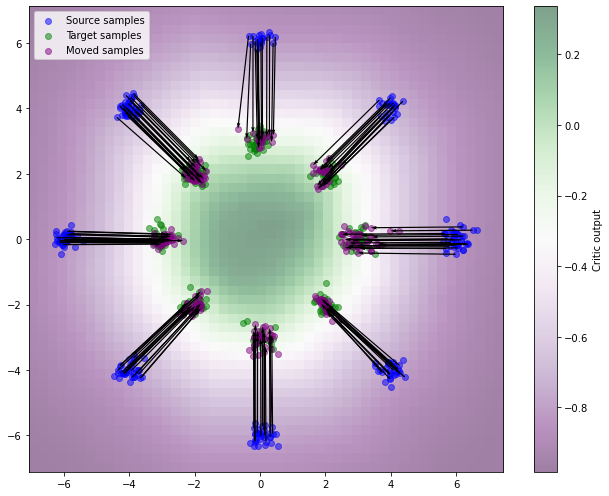

In [7]:
run_experiment(
    source, target,
    n_iter=2500,
    cost=SqOT(),
    plotter=Plotter(source_lims=((-8, 8), (-8, 8)),
                    target_lims=((-4, 4), (-4, 4)),
                    show_progress=False),
    logger=wandb_logger
)


### innerGW

wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


  0%|          | 0/5000 [00:00<?, ?it/s]

cost,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▂▁▂▁▂▃▂▂▂▃▂▃▃▄▃▃▃▄▃
loss,▆▁▁▂▂▂▂▂▃▃▂▂▃▁▂▃▁▄▃▃▄▄▄▅▅▆▆▅▆▅▆▆█▇█▇▅▇█▇
cost,0.19384
loss,0.66015


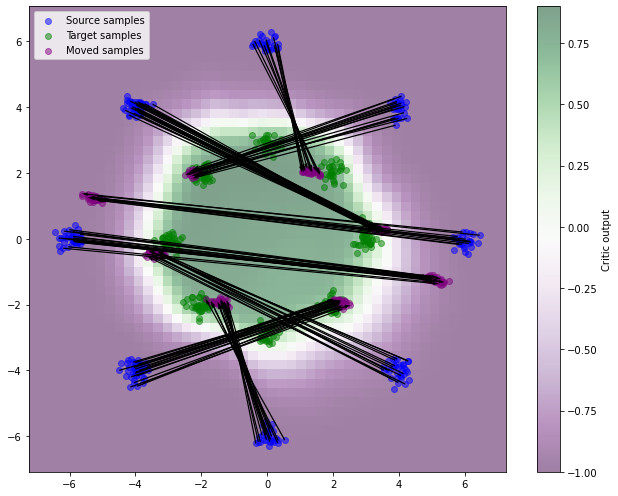

In [8]:
run_experiment(
    source, target,
    n_iter=5000,
    cost=InnerGW(l=.5),
    plotter=Plotter(source_lims=((-8, 8), (-8, 8)),
                    target_lims=((-4, 4), (-4, 4)),
                    show_progress=False
                   ),
    logger=wandb_logger
)
# 14

In [9]:
run_experiment(
    source, target,
    cost=SqGW_opt(2, 2, alpha=0., logger=wandb_logger),
    n_iter=5000,
    plotter=Plotter(source_lims=((-8, 8), (-8, 8)),
                    target_lims=((-4, 4), (-4, 4)),
                    show_progress=False
                   ),
    logger=wandb_logger
)


wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


  0%|          | 0/5000 [00:00<?, ?it/s]

### sqGW

In [ ]:
run_experiment(
    source, target,
    cost=SqGW(alpha=.01,),
    n_iter=5000,
    plotter=Plotter(source_lims=((-8, 8), (-8, 8)),
                    target_lims=((-4, 4), (-4, 4)),
                    # show_progress=False
                   ),
    # logger=wandb_logger
)

## Normal to Normal

In [ ]:
source = Normal(torch.tensor([3., 0.]), torch.tensor([1.,2.]))
target = Normal(torch.tensor([-3., 0.]), torch.tensor([1.,2.]))

### Regular OT

In [ ]:
run_experiment(
    source, target,
    n_iter=2500,
    cost=SqOT(),
    plotter=Plotter(source_lims=((-6, 6), (-6, 6)),
                    target_lims=((-6, 6), (-6, 6)),
                    show_progress=False),
    logger=wandb_logger
)


### innerGW

In [ ]:
run_experiment(
    source, target,
    n_iter=5000,
    cost=InnerGW(),
    plotter=Plotter(source_lims=((-6, 6), (-6, 6)),
                    target_lims=((-6, 6), (-6, 6)),
                    show_progress=False),
    logger=wandb_logger
)


In [ ]:
run_experiment(
    source, target,
    cost=SqGW_opt(2, 2, alpha=0., logger=wandb_logger),
    n_iter=5000,
    plotter=Plotter(source_lims=((-8, 8), (-8, 8)),
                    target_lims=((-4, 4), (-4, 4)),
                    show_progress=False
                   ),
    logger=wandb_logger
)


### sqGW

In [ ]:
run_experiment(
    source, target,
    n_iter=5000,
    cost=SqGW(alpha=.01),
    plotter=Plotter(source_lims=((-6, 6), (-6, 6)),
                    target_lims=((-6, 6), (-6, 6)),
                    show_progress=False),
    logger=wandb_logger
)

## Moon to Moon

In [ ]:
source = MoonsDistribution(upper=True, sigma=.1)
target = MoonsDistribution(upper=False, sigma=.1)

### Regular OT

In [ ]:
run_experiment(
    source, target,
    n_iter=2500,
    cost=SqOT(),
    plotter=Plotter(source_lims=None,
                    target_lims=None,
                    show_progress=False,
                    ),
    logger=wandb_logger
)


### innerGW

In [ ]:
run_experiment(
    source, target,
    n_iter=5000,
    cost=InnerGW(),
    plotter=Plotter(source_lims=None,
                    target_lims=None,
                    show_progress=False
                   ),
    logger=wandb_logger,
    n_inner_iter=2,
    log_plot_interval=50
)


In [ ]:
run_experiment(
    source, target,
    n_iter=5000,
    cost=SqGW_opt(2, 2, alpha=0., logger=wandb_logger),
    plotter=Plotter(source_lims=None,
                    target_lims=None,
                    show_progress=False
                   ),
    logger=wandb_logger,
    n_inner_iter=2,
)


## Normal to "57"

In [ ]:
source = Normal(torch.tensor([0., 0.]), torch.tensor([1.,2.]))

image = plt.imread("../../data/fifty-seven.png")[:, :, 3]
target = ImageDistribution(torch.from_numpy(image), 2., n_components=20000)

### Regular OT

In [ ]:
run_experiment(
    source, target,
    n_iter=2500,
    cost=SqOT(),
    plotter=Plotter(source_lims=((-4, 4), (-4, 4)),
                    target_lims=((-4, 4), (-4, 4)),
                    show_progress=False),
    logger=wandb_logger
)


### innerGW

In [ ]:
run_experiment(
    source, target,
    n_iter=5000,
    cost=InnerGW(),
    plotter=Plotter(source_lims=((-4, 4), (-4, 4)),
                    target_lims=((-4, 4), (-4, 4)),
                    show_progress=False),
    logger=wandb_logger
)


In [ ]:
run_experiment(
    source, target,
    n_iter=5000,
    cost=SqGW_opt(2, 2, alpha=0., logger=wandb_logger),
    plotter=Plotter(source_lims=None,
                    target_lims=None,
                    show_progress=False
                   ),
    logger=wandb_logger,
    # n_inner_iter=2,
)


### sqGW

In [ ]:
run_experiment(
    source, target,
    n_iter=5000,
    cost=SqGW(alpha=.0),
    plotter=Plotter(source_lims=((-4, 4), (-4, 4)),
                    target_lims=((-4, 4), (-4, 4)),
                    show_progress=False),
    logger=wandb_logger
)